In [1]:
import os
sample_files = []
for root, folders, files in os.walk(os.path.join('res', 'images')):
    for file in files:
        sample_files.append(os.path.join(root, file))
    break
sample_files

['res/images/sample1.jpg', 'res/images/sample2.jpg', 'res/images/sample3.jpg']

In [2]:
import math
def get_kernel_size(channels = 1, freq = 120, lookup_delay = 1):
    import cpuinfo
    processor = cpuinfo.get_cpu_info()
    clock = processor['hz_actual'][0]
    side = int(math.sqrt(clock) / (channels * lookup_delay * freq))
    return (side, side)

get_kernel_size(channels = 3)

(141, 141)

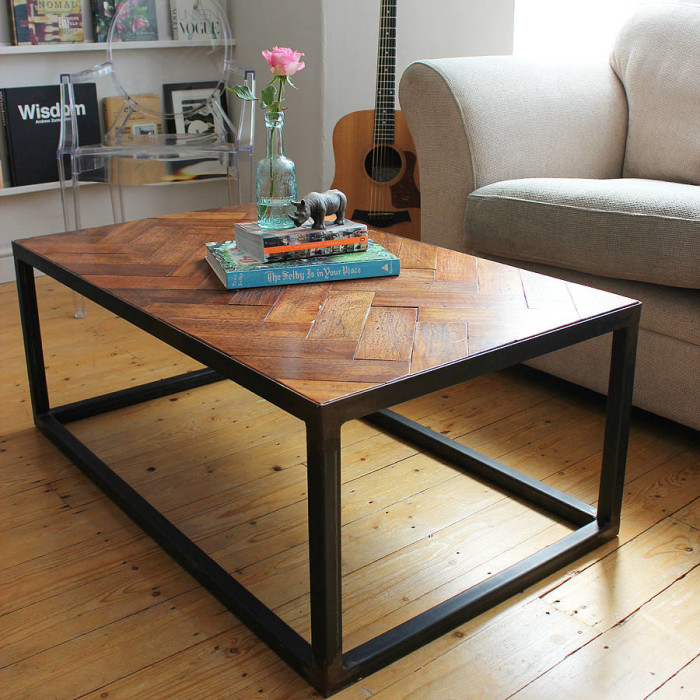

In [3]:
# check image

from IPython import display

display.Image(sample_files[0])

(280, 280) (420, 420)


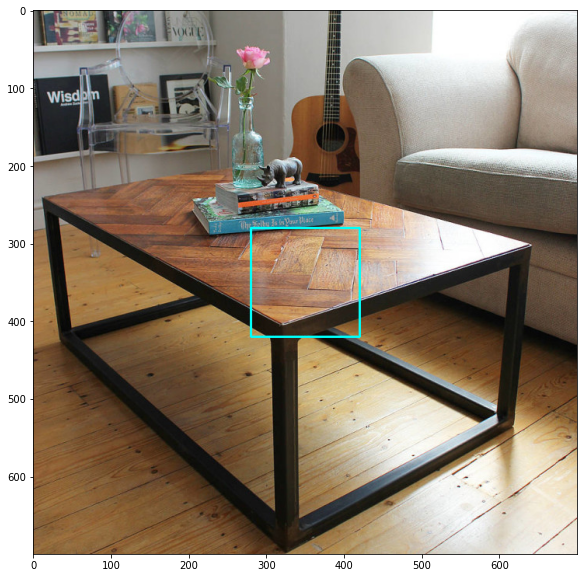

In [4]:
# Target : fit the data above into 'kernel_side' sized square
import cv2
# %matplotlib widget
# %matplotlib tk
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 10)

def show_kernel(filepath):
    image = cv2.imread(filepath)
    midpoint = (int(image.shape[0] / 2), int(image.shape[1] / 2))
    ksize = get_kernel_size(channels = image.shape[-1])
    delta = (int(ksize[0] / 2), int(ksize[1] / 2))
    start = (midpoint[1] - delta[1], midpoint[0] - delta[0])
    end = (midpoint[1] + delta[1], midpoint[0] + delta[0])
    print(start, end)
    image = cv2.rectangle(image, start, end, (250, 255, 0), 2)
    # cv2.imshow('test', image)
    # plt.rcParams["figure.figsize"] = (image.shape[0],image.shape[1])
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
show_kernel(sample_files[0])

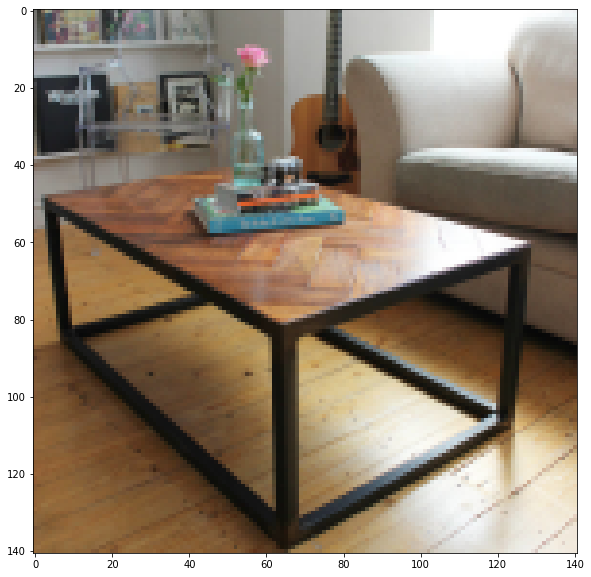

In [21]:
def make_uniform(data, interpolation = cv2.INTER_AREA, expect_output = False, expect_return = True, invert = False):
    image = None
    # sanity
    if isinstance(data, str):
        image = cv2.imread(data)
    elif isinstance(data, numpy.ndarray):
        image = data
    if image is None:
        raise Exception("Data provided is not recognized")
    # logic
    midpoint = (int(image.shape[0] / 2), int(image.shape[1] / 2))
    ksize = get_kernel_size(channels = image.shape[-1])
    if image.shape[0] != image.shape[1]:
        size = image.shape[0] if image.shape[0] < image.shape[1] else image.shape[1]
        delta = (int(size / 2), int(size / 2))
        start = (midpoint[1] - delta[1], midpoint[0] - delta[0])
        end = (midpoint[1] + delta[1], midpoint[0] + delta[0])
        image = image[start[1]:end[1], start[0]:end[0]]
    image = cv2.resize(image, ksize, interpolation = interpolation)
    # output
    if invert:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if expect_output:
        plt.imshow(image)
        plt.show()
    if expect_return:
        return image

# example
make_uniform(sample_files[0], expect_output = True, expect_return = False, invert=True)

(335, 497) (475, 637)


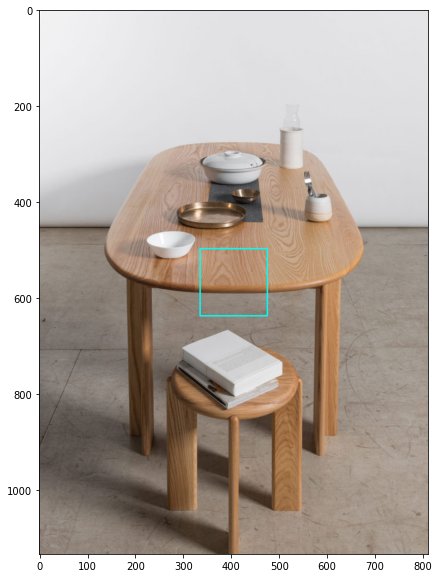

In [6]:
show_kernel(sample_files[1])

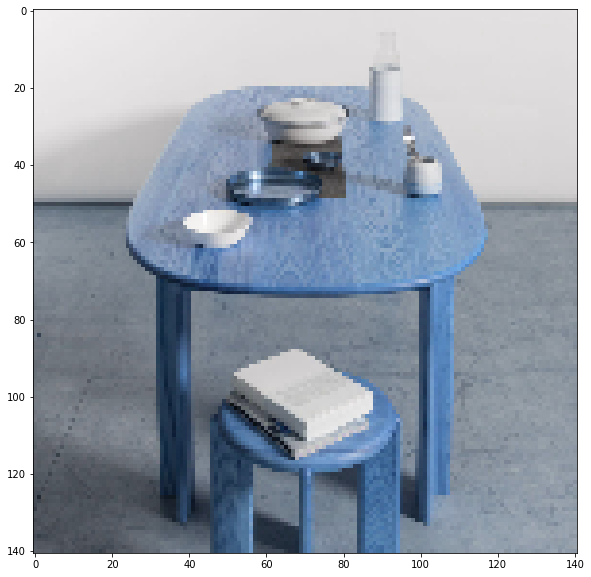

In [7]:
make_uniform(sample_files[1], interpolation = cv2.INTER_LINEAR_EXACT, expect_output = True, expect_return = False)

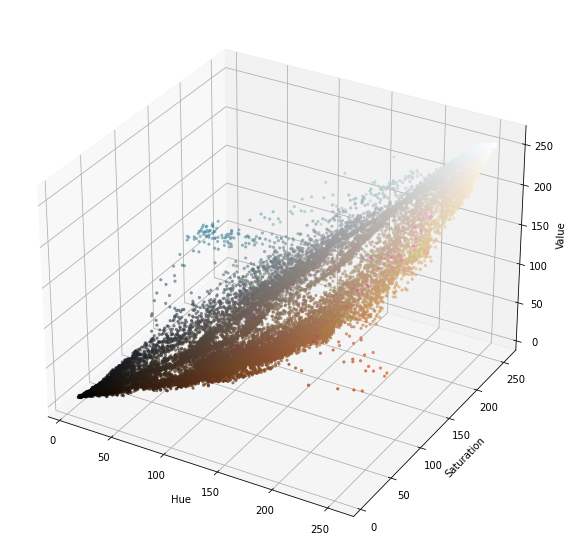

In [15]:
# Object segementation based on color
import numpy
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

image = make_uniform(sample_files[0], invert = True)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
hsv_image = image
h, s, v = cv2.split(hsv_image)

pixel_colors = image.reshape((numpy.shape(image)[0]*numpy.shape(image)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

fig = plt.figure()
# axis = Axes3D(fig)
axis = fig.add_subplot(1, 1, 1, projection="3d")
axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

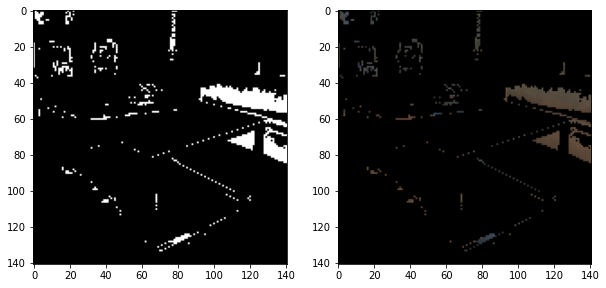

In [16]:
lower = (0, 50, 50)
higher = (100, 80, 100)
mask = cv2.inRange(hsv_image, lower, higher)
result = cv2.bitwise_and(image, image, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()
plt.close()

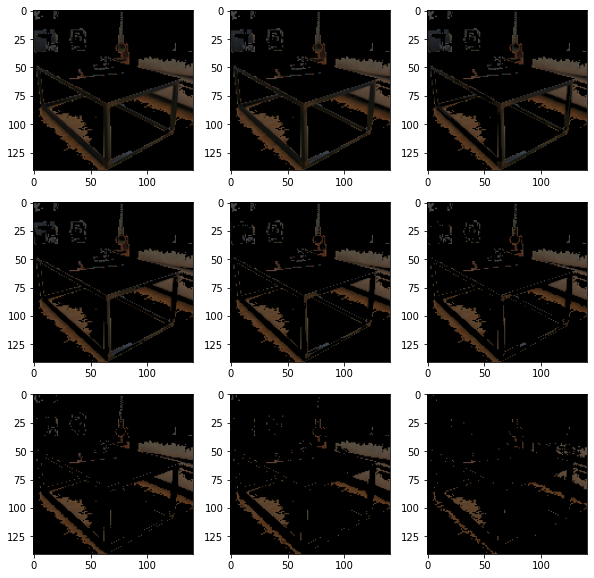

In [42]:
# total samples to be created for understanding
# the hsv selection : 9 for each of H, S and V
cols, rows = 3, 3
lim = 100
step = int(lim / 9)
adjusted_lim = step * 9
ctr = 1
for h in range(0, adjusted_lim, step):
    lower = (h, 0, 0)
    upper = (h + step, 100, 100)
    plt.subplot(cols, rows, ctr)
    mask = cv2.inRange(hsv_image, lower, higher)
    result = cv2.bitwise_and(image, image, mask=mask)
    plt.imshow(result)
    ctr += 1
plt.show()
plt.close()

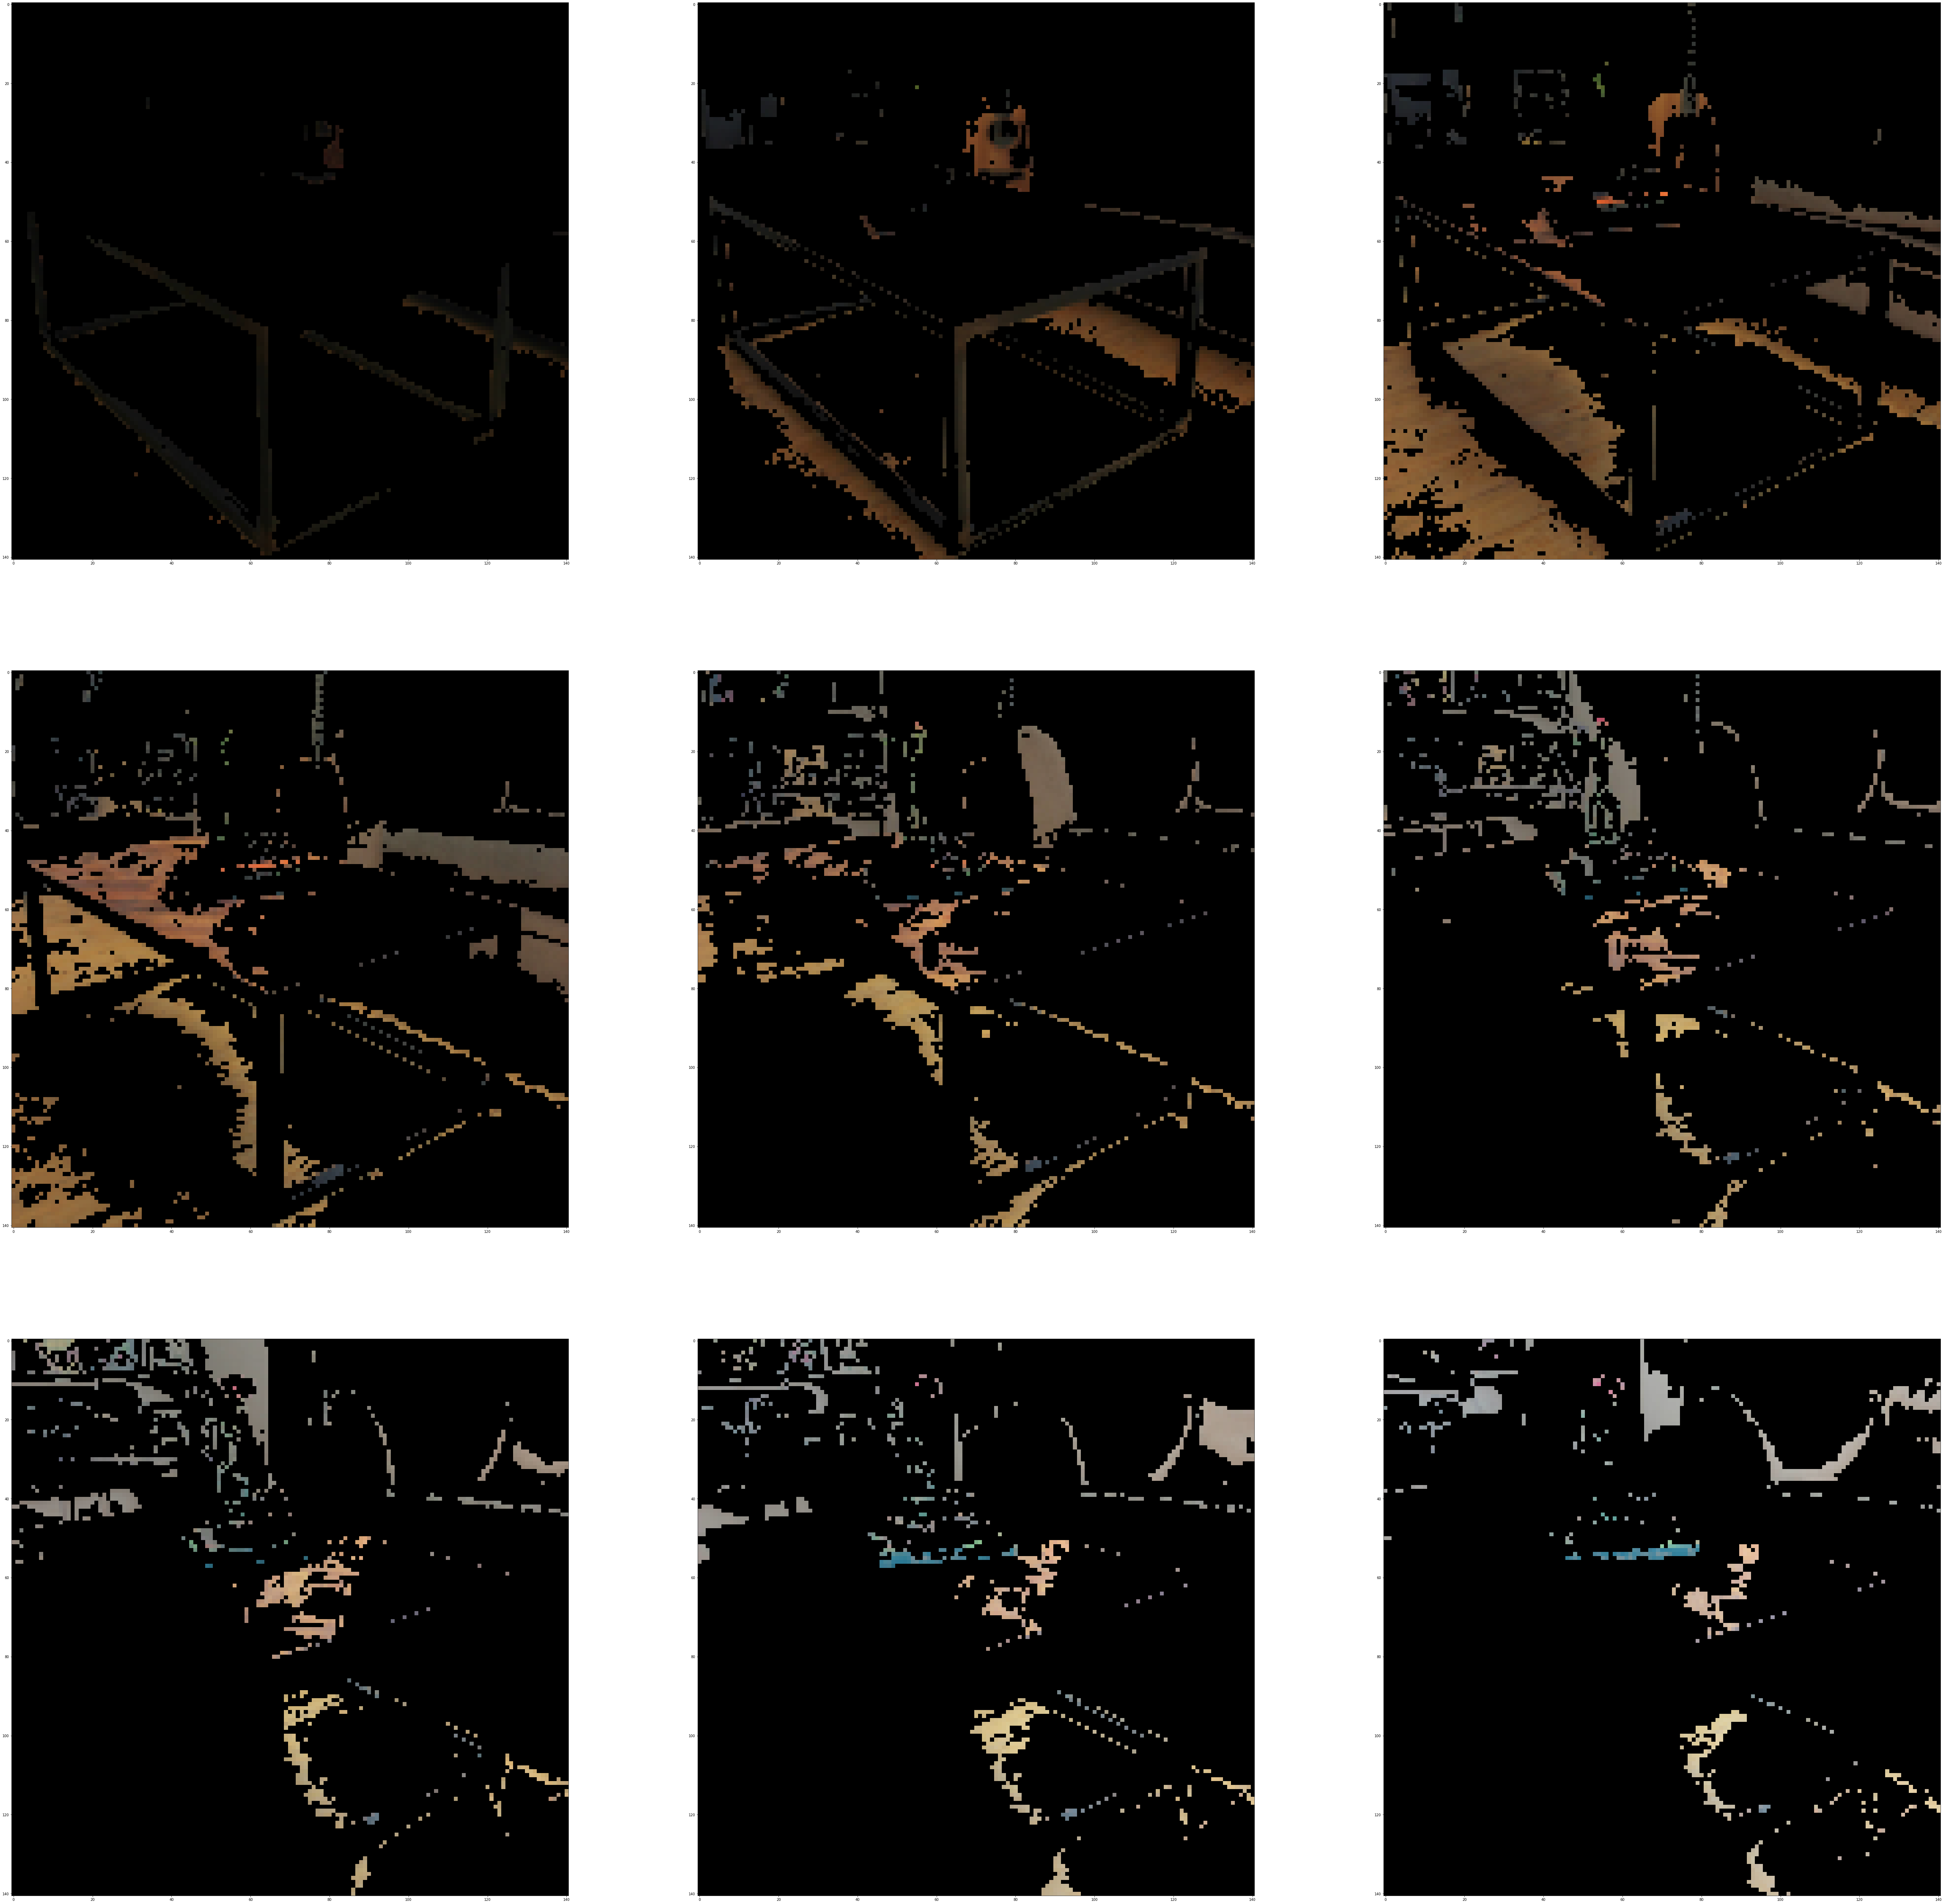

In [79]:
# change to parametric function
plt.rcParams["figure.figsize"] = (100, 100)
def color_space_test(c_img, index = 0, lim = 100, cols = 3, rows = 3, conversion = None):
    ''' Test color spaces using conversions, or feeding images and manipulating the parameters
    
    @author Supratik Chatterjee
    '''
    value_counts = cols * rows
    step = int(lim / value_counts)
    adjusted_lim = step * value_counts
    ctr = 1
    img = c_img
    lower = [0, 0, 0]
    upper = [255, 255, 255]
    if conversion != None:
        img = cv2.cvtColor(c_img, conversion)
        if conversion == cv2.COLOR_BGR2HSV:
            upper[0] = 179
    for x in range(0, adjusted_lim, step):
        lower[index] = x
        upper[index] = x + step
        plt.subplot(rows, cols, ctr)
        mask = cv2.inRange(img, tuple(lower), tuple(upper))
        result = cv2.bitwise_and(c_img, c_img, mask=mask)
        plt.imshow(result)
        ctr += 1
    plt.show()
    plt.close()

color_space_test(image, conversion=cv2.COLOR_BGR2RGB, cols = 3, rows=3, lim = 179)

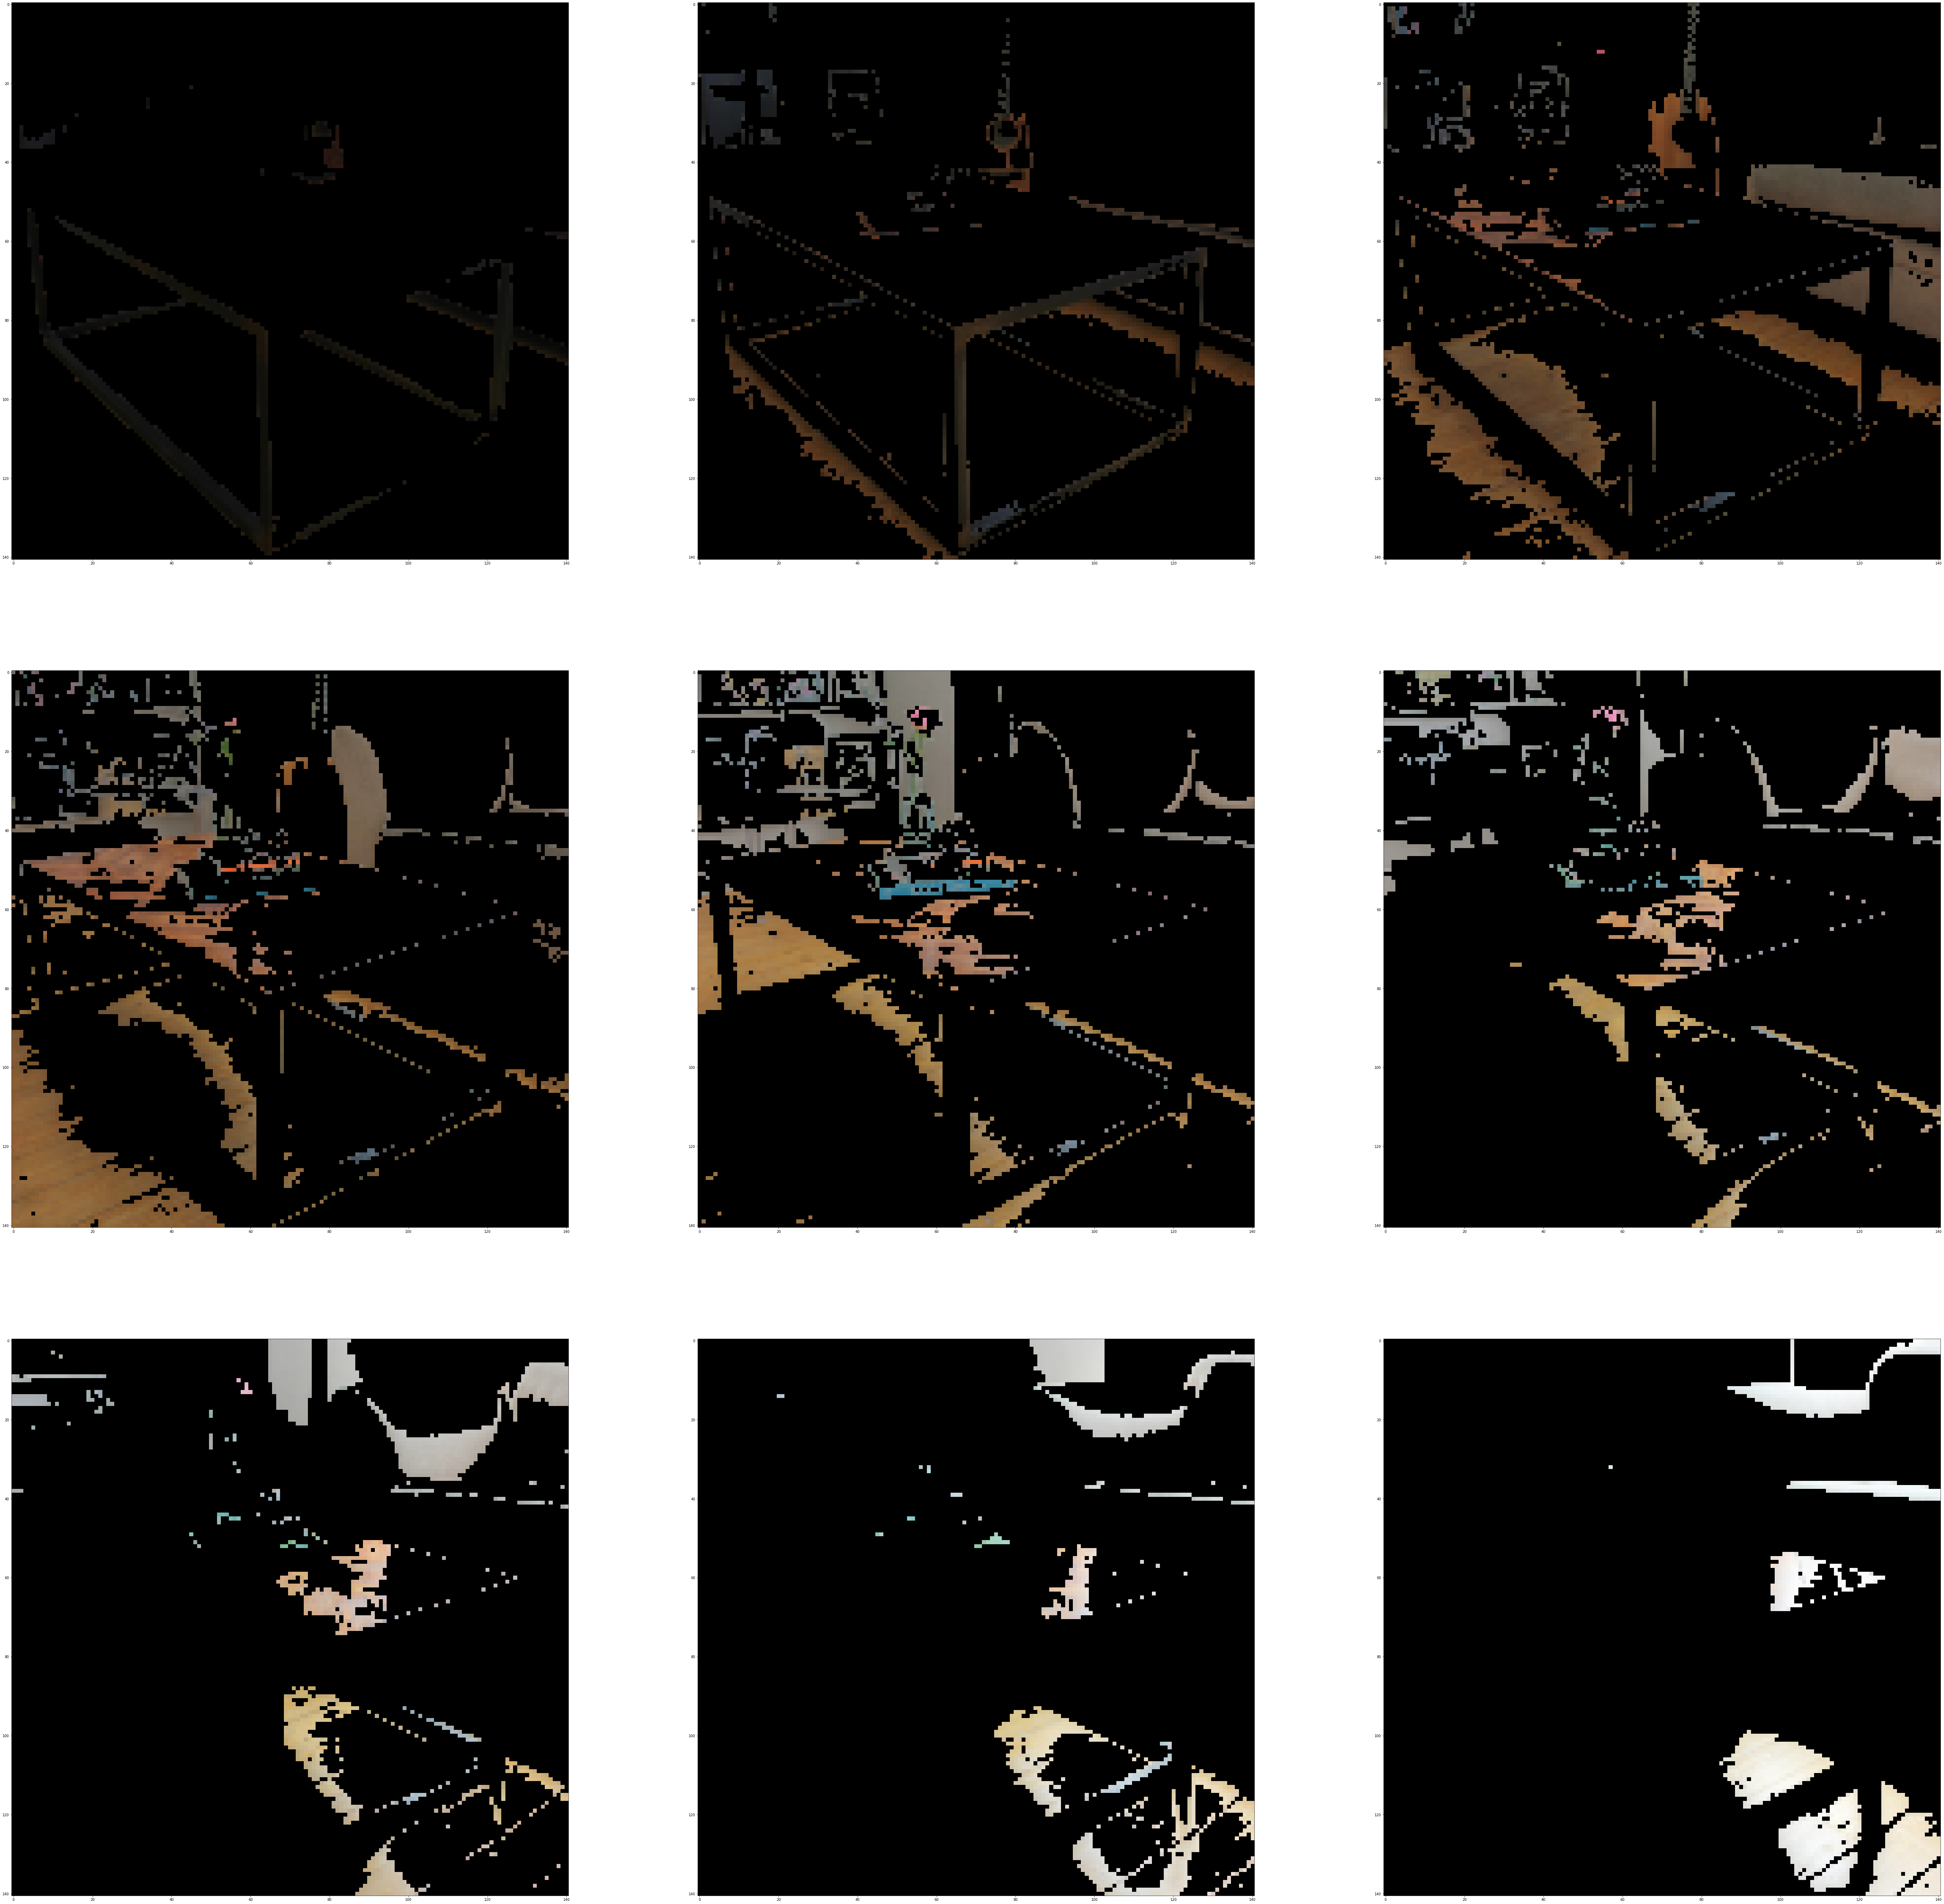

In [80]:
color_space_test(image, conversion=cv2.COLOR_BGR2RGB, cols = 3, rows = 3, index=1, lim = 255)

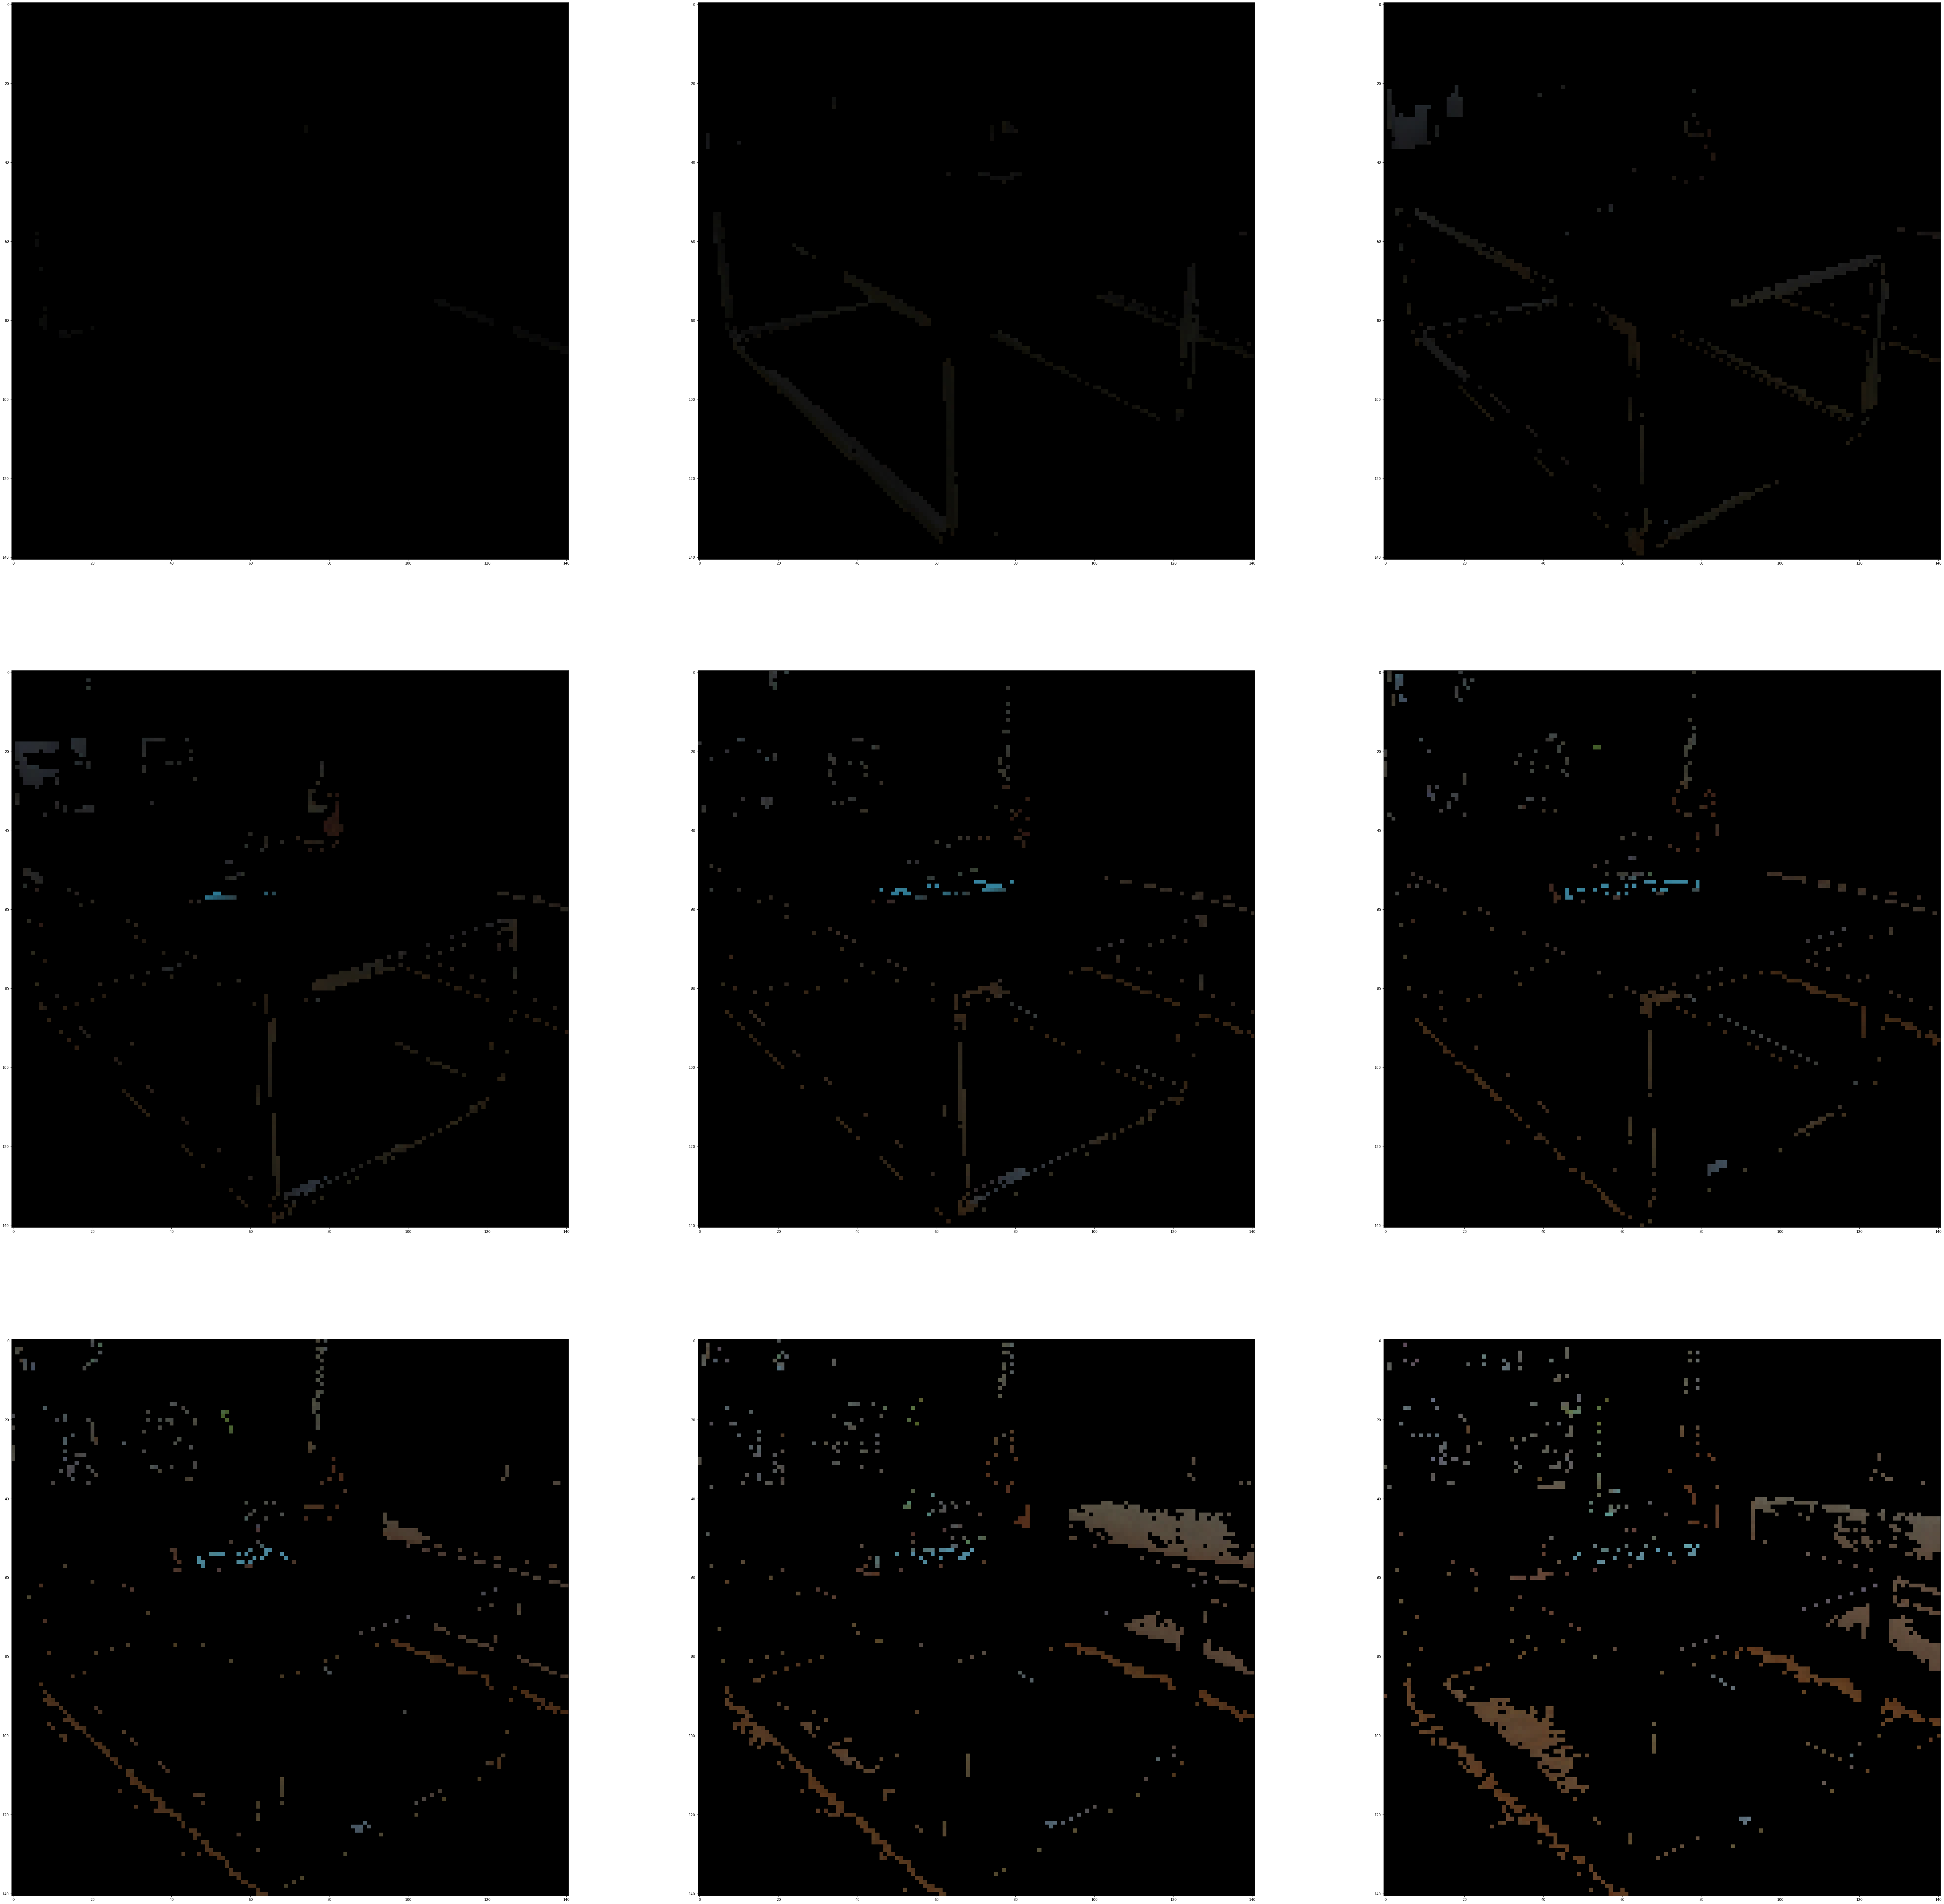

In [81]:
color_space_test(image, conversion=cv2.COLOR_BGR2RGB, cols = 3, rows=3, index=2)

In [82]:
# multi variate HSV based images

def color_space_test_multivariate(c_img, conversion = None, lims = (179, 255, 255), dim = (1, 1, 1)):
    ''' Shows multivariate samples on multivariates provided
    
    @param lims is used for defining the upper limit
    @param dim is used for defining the dimensions that the samples are to produce
    
    @author Supratik Chatterjee
    '''
    value_counts = dim[0] * dim[1] * dim[2]
    steps = [int(lim / value_counts) for lim in lims]
    adjusted_lims = [(step * value_counts) for step in steps]
    lower = [0, 0, 0]
    upper = list(lims)
    img = c_img
    if conversion != None:
        img = cv2.cvtColor(img, conversion)
    
    ctr = 1
    for x in range(0, adjusted_lims, step):
        for y in range
        lower[index] = x
        upper[index] = x + step
        plt.subplot(rows, cols, ctr)
        mask = cv2.inRange(img, tuple(lower), tuple(upper))
        result = cv2.bitwise_and(c_img, c_img, mask=mask)
        plt.imshow(result)
        ctr += 1
    plt.show()
    plt.close()

SyntaxError: invalid syntax (555547396.py, line 22)

In [83]:
color_space_test?